# Analysis of Zenodo data

## Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml

# Update font size for graphics
plt.rcParams.update({'font.size': 20})

## Load data

In [2]:
datasets = pd.read_csv("../data/zenodo_datasets.tsv", sep="\t")
print(f"Found {datasets.shape[0]} datasets.")
files = pd.read_csv("../data/zenodo_files.tsv", sep="\t")
print(f"Found {files.shape[0]} files.")

Found 872 datasets.
Found 146235 files.


/tmp/ipykernel_309014/907671346.py:3: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  files = pd.read_csv("../data/zenodo_files.tsv", sep="\t")


Merge both dataframes.
One dataset can be associated to many files.

In [3]:
tab = pd.merge(files, datasets, how="left", on=["dataset_id", "origin"], validate="many_to_one")
print(f"Dataframe has {tab.shape[0]} entries.")

Dataframe has 146235 entries.


In [4]:
tab.columns

Index(['dataset_id', 'origin', 'file_type', 'file_size', 'file_md5',
       'from_zip_file', 'file_name', 'file_url', 'origin_zip_file', 'doi',
       'date_creation', 'date_last_modified', 'date_fetched', 'file_number',
       'download_number', 'view_number', 'license', 'title', 'author',
       'keywords', 'dataset_url'],
      dtype='object')

## Read query parameters

In [5]:
def read_query_file(filename):
    """File query.yml parser.

    This function parses the query file.

    Parameters
    ----------
    filename : str
        Filename for query parameters.
    
    Returns
    -------
    file_types : dict
        Dictionary with type, engine, keywords to use and category
    """
    with open(filename, "r") as param_file:
        data_loaded = yaml.safe_load(param_file)
    file_types = data_loaded["file_types"]
    return file_types

In [6]:
dico_file_types = read_query_file("../params/query.yml")

ext_gromacs = []
ext_namd = []
ext_amber = []

list_coordinate = []
list_trajectory = []
list_topology = []

for dico in dico_file_types:
    if dico["engine"] == "gromacs":
        ext_gromacs.append(dico["type"])
    elif dico["engine"] == "namd":
        ext_namd.append(dico["type"])
    elif dico["engine"] == "amber":
        ext_amber.append(dico["type"])
    
    if dico["category"] == "coordinate":
        list_coordinate.append(dico["type"])
    elif dico["category"] == "topology":
        list_topology.append(dico["type"])
    elif dico["category"] == "trajectory":
        list_trajectory.append(dico["type"])

ext_all = ext_gromacs + ext_namd + ext_amber
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

## Compute number of keywords for each dataset

Average number of keywords per dataset: 2.37


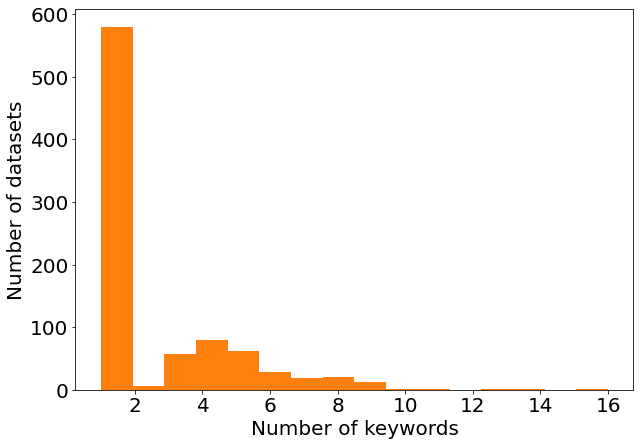

In [7]:
def count_keywords(keywords):
    """Count number of keywords.
    
    Keywords are separated by ; or ,
    
    Parameters
    ----------
    keywords : str
        Keywords.
    
    Returns
    -------
    int
        Number of keywords.
    """
    keywords = str(keywords)
    if keywords and keywords not in ["None", "nan"]:
        keywords_lst = keywords.replace(",", ";").split(";")
        return len(keywords_lst)
    else:
        return 0

datasets["keywords_nb"] = datasets["keywords"].apply(count_keywords)
datasets["keywords_nb"].value_counts()

plt.figure(figsize=(10,7))
plt.hist(datasets["keywords_nb"], 
         bins=max(datasets["keywords_nb"]),
         color="tab:orange")
plt.xlabel("Number of keywords")
plt.ylabel("Number of datasets")
plt.savefig("number_of_keywords_per_dataset.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_keywords_per_dataset.svg", bbox_inches="tight")

print(f"Average number of keywords per dataset: {datasets['keywords_nb'].mean():.2f}")

## Assign MD engine per file

In [8]:
def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in ext_namd:
        return "NAMD"
    elif file_type in ext_amber:
        return "AMBER"
    else:
        return "unknown"

tab["engine_MD"] = tab["file_type"].apply(assign_md_engine)
tab["engine_MD"].value_counts()

unknown    91747
GROMACS    44513
AMBER       5237
NAMD        4738
Name: engine_MD, dtype: int64

## Assign file category

In [9]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

tab["category"] = tab["file_type"].apply(assign_file_category)
tab["category"].value_counts()

none          91747
trajectory    29609
topology      13040
coordinate    11839
Name: category, dtype: int64

## Extract year from date

In [10]:
tab["year"] = tab["date_creation"].apply(lambda x: int(x[:4]))
datasets["year"] = datasets["date_creation"].apply(lambda x: int(x[:4]))

## Count number of files per dataset (without zip content)

In [11]:
(tab
 .query("from_zip_file == False")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .describe()
)

,file_nb
count,872.000000
mean,17.769495
std,37.882207
min,1.000000
25%,4.000000
50%,9.000000
75%,16.000000
max,800.000000


Datasets with the most files:

In [12]:
(tab
 .query("from_zip_file == False")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .sort_values(by=["file_nb"], ascending=False)
 .head()
)

,file_nb,dataset_url
dataset_id,,
4056037,800,https://zenodo.org/record/4056037
825048,332,https://zenodo.org/record/825048
4627963,230,https://zenodo.org/record/4627963
238943,217,https://zenodo.org/record/238943
825185,189,https://zenodo.org/record/825185


## Count number of files per dataset (with zip content)

In [13]:
(tab
 .query("file_type != 'zip'")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .describe()
)

,file_nb
count,872.000000
mean,166.170872
std,575.895636
min,1.000000
25%,9.000000
50%,16.000000
75%,59.000000
max,12030.000000


Datasets with the most files:

In [14]:
(tab
 .query("file_type != 'zip'")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .sort_values(by=["file_nb"], ascending=False)
 .head()
)

,file_nb,dataset_url
dataset_id,,
6477772,12030,https://zenodo.org/record/6477772
3780467,4280,https://zenodo.org/record/3780467
5797177,3897,https://zenodo.org/record/5797177
4650406,3538,https://zenodo.org/record/4650406
2547317,3351,https://zenodo.org/record/2547317


## Count average number of views and downloads per dataset

In [15]:
(datasets
 .loc[:,["view_number", "download_number"]]
 .describe()
)

,view_number,download_number
count,872.000000,872.000000
mean,84.850917,126.805046
std,375.576096,280.761174
min,0.000000,0.000000
25%,23.000000,15.000000
50%,41.000000,51.000000
75%,67.000000,114.250000
max,8767.000000,3908.000000


Datasets with the most downloads:

In [16]:
(datasets
 .loc[:,["dataset_url", "download_number"]]
 .sort_values(by=["download_number"], ascending=False)
 .head()
)

,dataset_url,download_number
454,https://zenodo.org/record/825048,3908
780,https://zenodo.org/record/167336,2821
246,https://zenodo.org/record/238943,2645
77,https://zenodo.org/record/3237420,1867
480,https://zenodo.org/record/3604448,1741


For Zenodo, we might want to considere [*Unique downloads*](https://help.zenodo.org/#statistics) instead

## Total size of all files with zip files

In TB, zip files included, zip files content excluded.

In [17]:
(tab
 .query("from_zip_file == False")
 .loc[:, "file_size"]
 .sum()/10**12
)

9.703409919078

## Total size of all files without zip files

In TB, zip files excluded, zip files content included.

This is the most realistic size.

In [18]:
(tab
 .query("file_type != 'zip'")
 .loc[:, "file_size"]
 .sum()/10**12
)

9.435687999595

## Remove zip files

We remove zip files but keep not their content.

In [19]:
files_nb_before = tab.shape[0]
tab = tab[tab["file_type"] != "zip"]
print(f"Remove {files_nb_before - tab.shape[0]} zip files.")

Remove 1334 zip files.


## Average number of files per dataset

In [20]:
print(f"A dataset contains on average {tab.groupby(['dataset_id'])['file_md5'].size().mean():.0f} files.")

A dataset contains on average 166 files.


## Analysis

### Number of files per MD engine

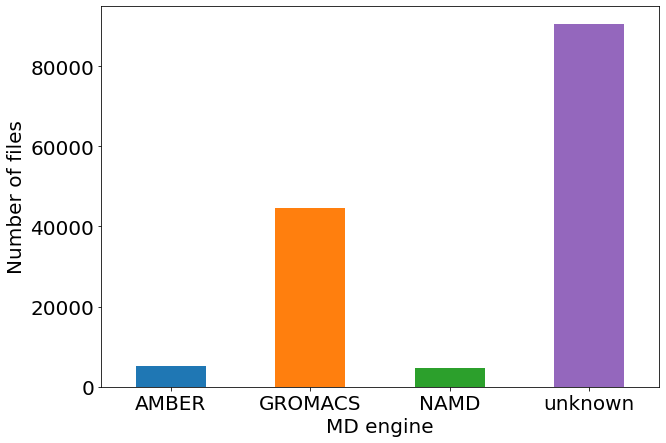

In [21]:
(tab
 .loc[:, "engine_MD"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple"], figsize=(10,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_MD_engine.svg", bbox_inches="tight")

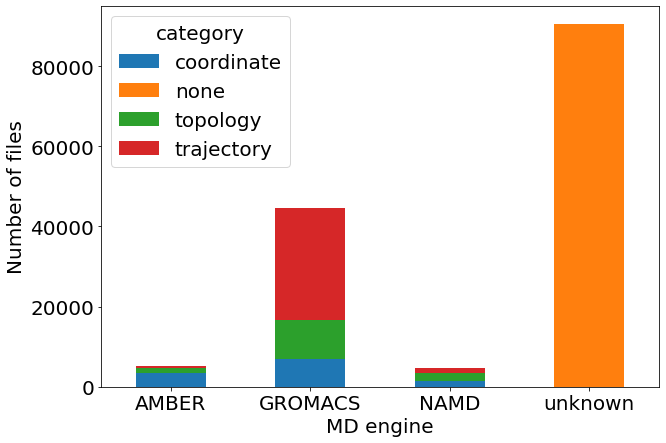

In [23]:
(tab
 .groupby("engine_MD")["category"]
 .value_counts()
 .unstack()
 .plot.bar(stacked=True, figsize=(10,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_MD_engine_per_categories.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_MD_engine_per_categories.svg", bbox_inches="tight")

#### Number of datasets per years

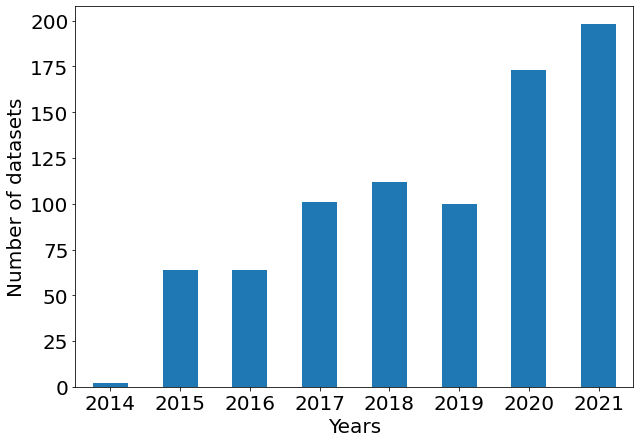

In [24]:
(datasets
 .query("year != 2022")
 .groupby(["year"])["dataset_id"]
 .size()
 .plot(kind="bar", figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of datasets")
plt.savefig("number_of_datasets_per_years.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_datasets_per_years.svg", bbox_inches="tight")

### Number of files per years

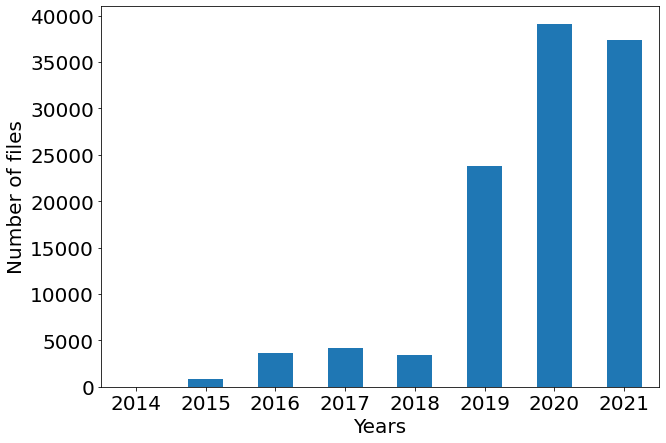

In [25]:
(tab
 .query("year != 2022")
 .loc[:, "year"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_years.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_years.svg", bbox_inches="tight")

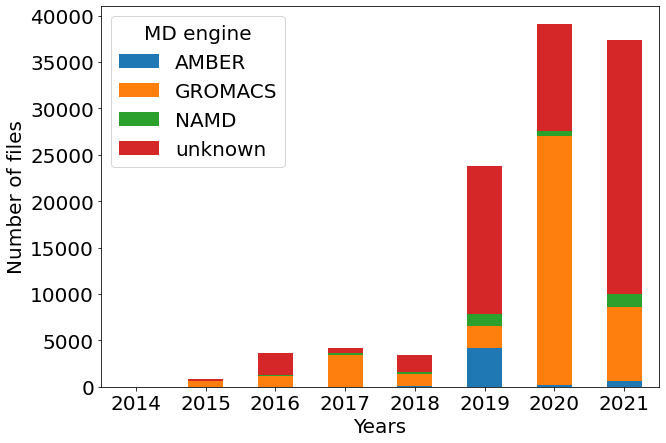

In [26]:
(tab
 .query("year != 2022")
 .groupby(["year", "engine_MD"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="MD engine")
plt.savefig("number_of_files_per_years_per_MD_engines.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_years_per_MD_engines.svg", bbox_inches="tight")

### Number of files per filetype

For files not associated to MD engine.

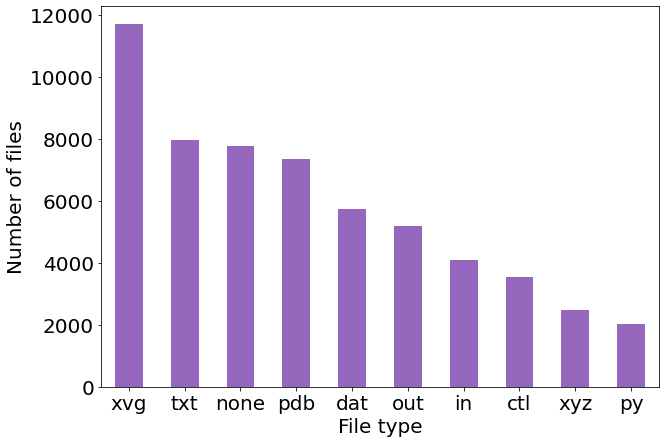

In [29]:
(tab
 .query("engine_MD == 'unknown'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="tab:purple", figsize=(10,7))
)
plt.xlabel("File type")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_filetype_no_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_filetype_no_MD_engine.svg", bbox_inches="tight")

#### For Gromacs

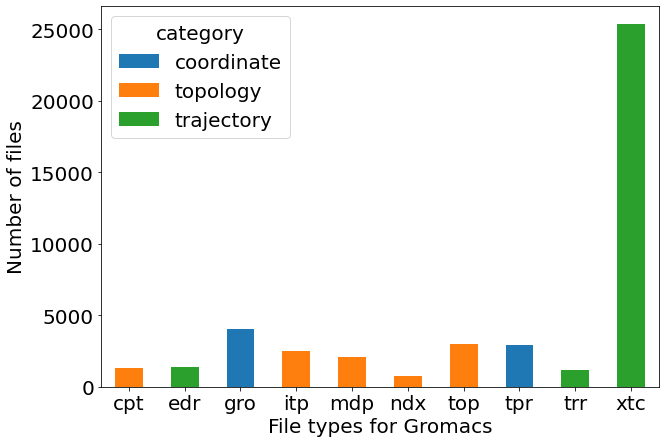

In [45]:
(tab
 .query("file_type in @ext_gromacs")
 .groupby("file_type")["category"]
 .value_counts()
 .unstack().plot.bar(stacked=True, figsize=(10,7))
)
plt.xlabel("File types for Gromacs")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_filetype_gromacs.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_filetype_gromacs.svg", bbox_inches="tight")

### File size per year

- in TB
- In Zenodo, individual file size cannot go above 50 GB (see [FAQ](https://help.zenodo.org/)).

In [37]:
(tab.groupby(["year"])["file_size"].sum()/10**12)

year
2014    0.000740
2015    0.156826
2016    0.144266
2017    1.216157
2018    1.183853
2019    1.338739
2020    2.647268
2021    1.938335
2022    0.809503
Name: file_size, dtype: float64

### Comparison with figshare data

#### Load data

In [39]:
datasets_f = pd.read_csv("../figshare_datasets.tsv", sep="\t")
print(f"Found {datasets_f.shape[0]} datasets.")
files_f = pd.read_csv("../figshare_files.tsv", sep="\t")
print(f"Found {files_f.shape[0]} files.")

Found 91 datasets.
Found 18796 files.


Merge both dataframes. One dataset can be associated to many files.

In [40]:
tab_f = pd.merge(files_f, datasets_f, how="left", on=["dataset_id", "origin"], validate="many_to_one")
print(f"Found {tab_f.shape[0]} rows.")

Found 18796 rows.


#### Extract year from date

In [41]:
tab_f["years"] = tab_f["date_creation"].apply(lambda x: int(x[:4]))
datasets_f["years"] = datasets_f["date_creation"].apply(lambda x: int(x[:4]))

#### Concatenation of data

In [42]:
tot = pd.concat([tab, tab_f])
datasets_tot = pd.concat([datasets, datasets_f])
print(f"Found {datasets.shape[0]} datasets.")
print(f"Found {datasets_f.shape[0]} datasets.")
print(f"Found {datasets_tot.shape[0]} datasets.")

Found 872 datasets.
Found 91 datasets.
Found 963 datasets.


#### Analysis

##### Number of datasets per years

Text(0, 0.5, 'Number of datasets')

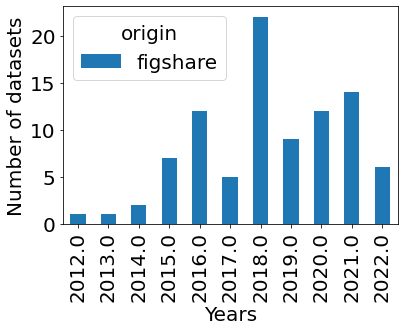

In [43]:
datasets_tot.groupby(["years", "origin"])["dataset_id"].size().unstack().plot(kind="bar", stacked=False)
plt.xlabel("Years")
plt.ylabel("Number of datasets")


##### Number of datasets per years

Text(0, 0.5, 'Number of files')

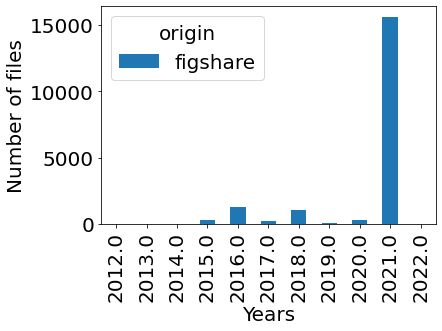

In [44]:
tot.groupby(["years", "origin"]).size().unstack().plot(kind="bar", stacked=False)
plt.xlabel("Years")
plt.ylabel("Number of files")